In [1]:
# 基本庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os

# Darts - 時間序列相關庫
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.metrics.metrics import mape, mae, mse, ape

from chronos import ChronosPipeline

from sklearn.preprocessing import MinMaxScaler
from tools.callbacks import LossLoggingCallback
from tools.calculate_95_ci import calculate_95_ci
from tools.calculate_metrics import calculate_metrics
from tools.data_loader import load_and_preprocess_data

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
location = 'Chiayi' 
model_type = 'Chronos' 
location_params = {
    'Linkou': {'train_end': 3362, 'val_end': 3727},
    'Taipei': {'train_end': 3372, 'val_end': 3737},
    'Kaohsiung': {'train_end': 3208, 'val_end': 3573},
    'Keelung': {'train_end': 3274, 'val_end': 3639},
    'Yunlin': {'train_end': 2557, 'val_end': 2922},
    'Chiayi': {'train_end': 3237, 'val_end': 3602}
}

#Data loading

In [5]:
file_name = f'EDvisitfile{location}.csv'
file_path = os.path.join('..', 'DataSet', file_name)
df = pd.read_csv(file_path, encoding='ISO-8859-1')

total_length = len(df)
train_end =location_params[location]['val_end']

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)


train_df = df.iloc[:train_end]
test_df = df.iloc[train_end:]
all_df = df[['No']]

all_series = TimeSeries.from_dataframe(
    all_df,
    value_cols='No')

#Model

In [7]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-small",
  device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
  torch_dtype=torch.bfloat16,
)

context_array = train_df['No'].to_numpy().astype('float32')
context_tensor = torch.tensor(context_array, dtype=torch.bfloat16)

In [8]:
prediction_length = 7
window_size = location_params[location]['train_end']
batch_interval = 7

extended_train_df = train_df.copy()
last_forecast_date = extended_train_df.index.max()  # 追蹤最新的日期

# Initialize all_forecasts as an empty DataFrame with the same columns as forecast_df
all_forecasts = pd.DataFrame(columns=['No'])

# Loop over the test data in steps of batch_interval
for i in range(0, len(test_df), batch_interval):
    # Check if prediction would exceed the test data
    if i + prediction_length >= len(test_df):
        break

    # Use a sliding window of data for the context (history for predictions)
    if len(extended_train_df) > window_size:
        context_df = extended_train_df.iloc[-window_size:]  # Use last 'window_size' entries
    else:
        context_df = extended_train_df

    # Prepare the context as a tensor for the model
    context_array = context_df['No'].to_numpy().astype('float32')
    context_tensor = torch.tensor(context_array).unsqueeze(0)  # Add batch dimension

    # Generate forecast for the next 'prediction_length' days
    forecast = pipeline.predict(
        context=context_tensor,
        prediction_length=prediction_length,
        num_samples=1,  # Number of samples for probabilistic forecasting
        temperature=0.6,
        top_k=10,
        top_p=1.0,
        limit_prediction_length=False
    )

    # Squeeze the forecast to remove the extra dimensions
    forecast_flattened = forecast.squeeze().numpy()
    
    # Ensure that forecast_flattened is a 1D array
    if forecast_flattened.ndim == 0:  # if it's a scalar
        forecast_flattened = np.array([forecast_flattened])  # convert to 1D array
    
    # Generate the forecast date range by starting from the last forecast date
    forecast_dates = pd.date_range(start=last_forecast_date + pd.Timedelta(days=1), periods=len(forecast_flattened))
    
    # Create a DataFrame for the predicted days with the correct date range
    forecast_df = pd.DataFrame(
        data=forecast_flattened,
        index=forecast_dates,
        columns=['No']
    )

    # Append the current batch of forecasts to the overall DataFrame
    all_forecasts = pd.concat([all_forecasts, forecast_df])

    # 更新最後預測的日期，為此次預測的最後一個日期
    last_forecast_date = forecast_dates[-1]

    # Update the extended training set with actuals from the test data
    actual_data_to_add = test_df.iloc[i:i+batch_interval]
    extended_train_df = pd.concat([extended_train_df, actual_data_to_add])

# Optionally, reset the index if needed
all_forecasts.reset_index(inplace=True)
all_forecasts.rename(columns={'index': 'Date'}, inplace=True)

In [9]:
all_forecasts['Date'] = pd.to_datetime(all_forecasts['Date'])

# Filter the DataFrame to start from the specific date
start_date = '2018-01-01'
filtered_forecasts = all_forecasts[all_forecasts['Date'] >= start_date]

# Convert the filtered DataFrame to a TimeSeries
Model_prediction_ts_inverse = TimeSeries.from_dataframe(
    filtered_forecasts,
    time_col='Date',
    value_cols='No'
)

#Calculate error and visualization

In [11]:
MAPE = mape(all_series, Model_prediction_ts_inverse)
MAE = mae(all_series, Model_prediction_ts_inverse)
APE= ape(all_series, Model_prediction_ts_inverse)

In [12]:
APEdf = pd.DataFrame(APE, columns=['APE'])
time_index = pd.date_range(start='2018-01-01', periods=len(APEdf), freq='D')
APEdf.index = time_index

In [13]:
yearly_dataarrays = {}

for year in range(2018, 2023):  # 从2017到2022
    yearly_series = Model_prediction_ts_inverse.slice(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
    yearly_dataarrays[year] = yearly_series.data_array()

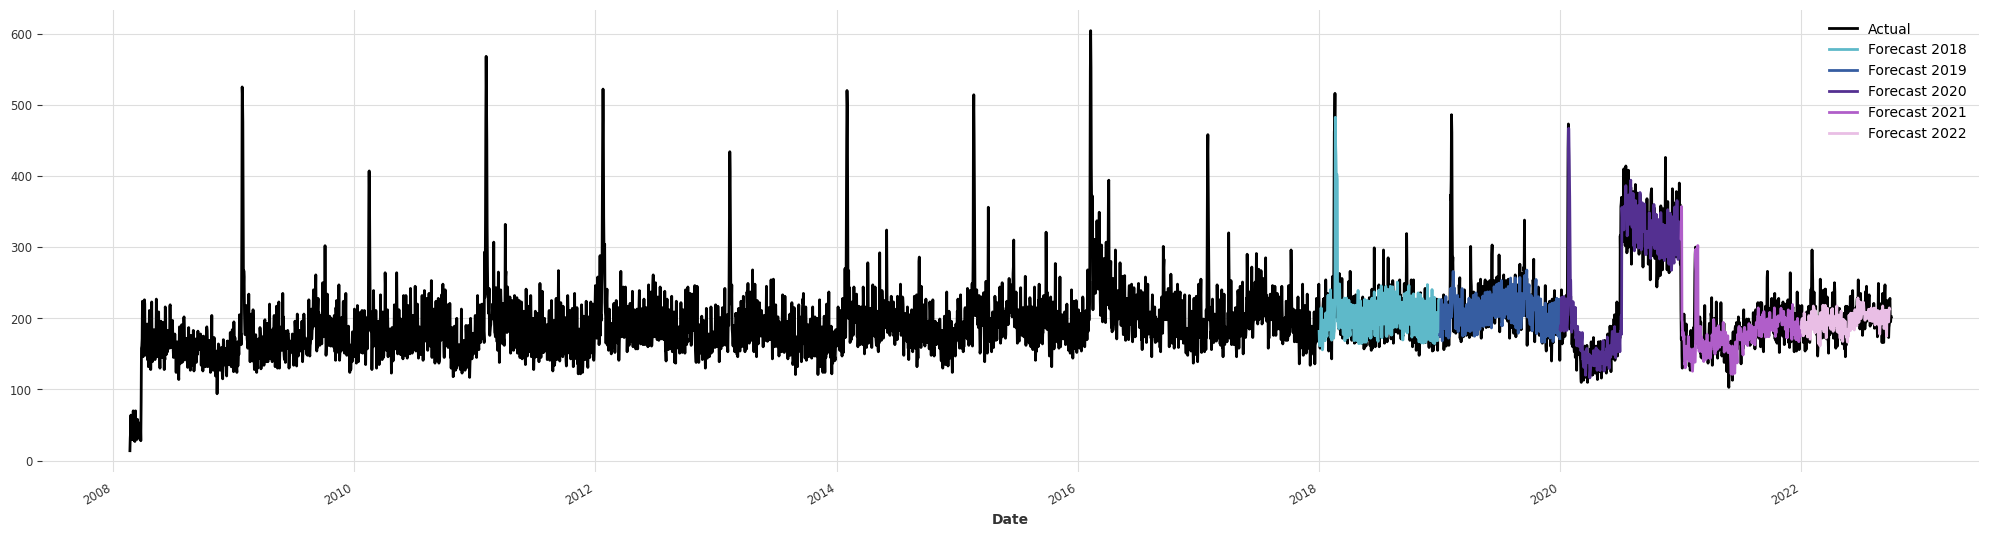

In [14]:
plt.figure(figsize=(25, 6))

# 绘制实际数据
all_series.plot(label="Actual", color='black')

# 为2018到2022年的每个年份绘制预测数据
colors = ['#5EB9C9', '#365DA1', '#543091', '#B05EC9', '#E9BEE5']   # 为每个年份指定一个颜色
for i, year in enumerate(range(2018, 2023)):
    # 将DataArray转换回TimeSeries以便使用plot方法
    # 注意：这里假设yearly_dataarrays中存储的是DataArray对象
    ts = TimeSeries.from_xarray(yearly_dataarrays[year])
    
    # 绘制每年的预测数据
    ts.plot(label=f"Forecast {year}", color=colors[i])

# 添加图例
plt.legend()

# 显示图表
plt.show()

#Save prediction

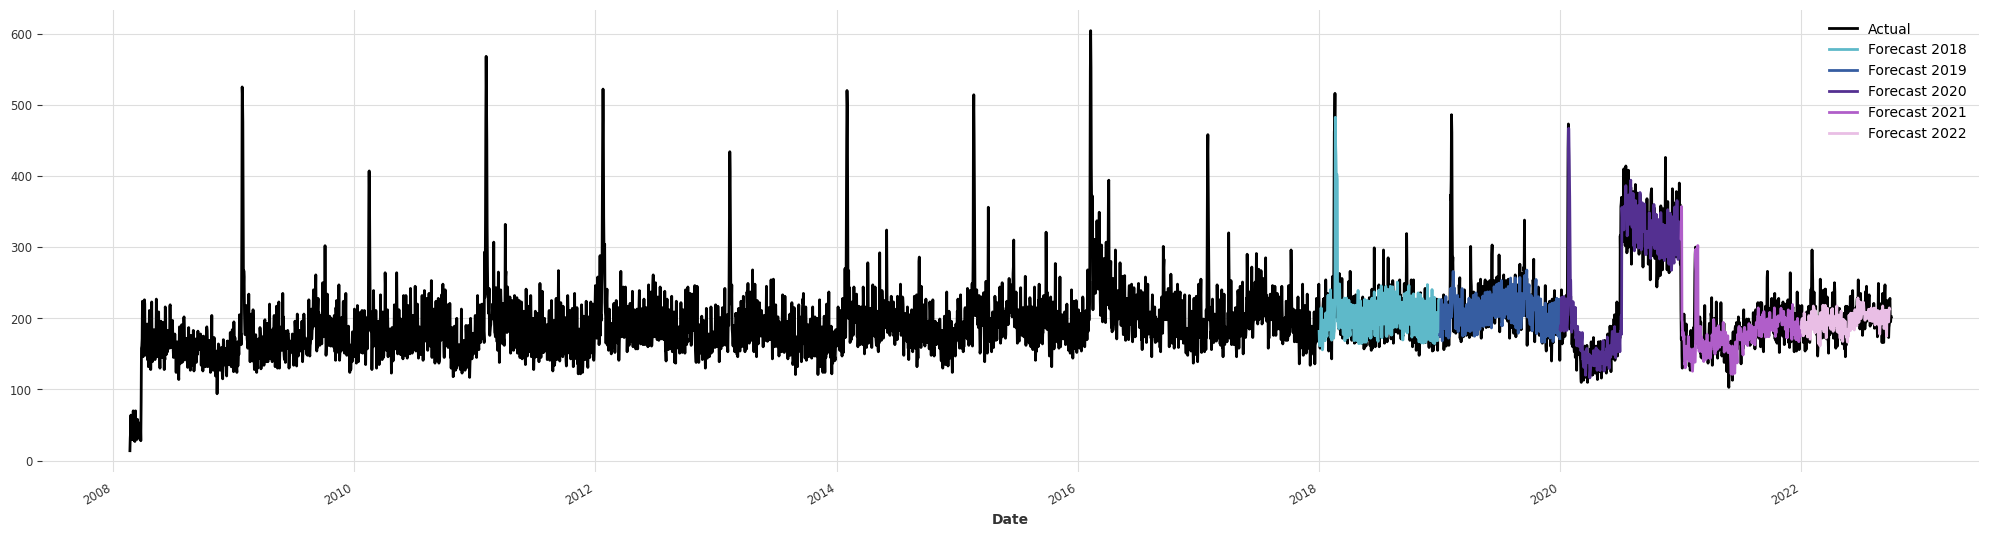

Forecast plot saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\Chronos\Chiayi\Chiayi_Chronos_FH7_forecast_plot.png
Metrics saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\Chronos\Chiayi\Chiayi_Chronos_FH7_metrics.txt
Model_prediction_df_inverse saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\Chronos\Chiayi\Chiayi_Chronos_FH7.csv


In [16]:
forecast_horizon_label = f"FH{prediction_length}"

# Define paths for the result files, using 'FH30' in the filenames
base_dir = os.path.abspath(os.path.join('..', 'Result', model_type, location))
plot_path = os.path.join(base_dir, f'{location}_{model_type}_{forecast_horizon_label}_forecast_plot.png')
metrics_txt_path = os.path.join(base_dir, f'{location}_{model_type}_{forecast_horizon_label}_metrics.txt')

# Ensure that the directories exist
os.makedirs(base_dir, exist_ok=True)

# Plot the actual and forecast data
plt.figure(figsize=(25, 6))

# Plot the actual data
all_series.plot(label="Actual", color='black')

# Plot forecast data for each year (2018-2022)
colors = ['#5EB9C9', '#365DA1', '#543091', '#B05EC9', '#E9BEE5']
for i, year in enumerate(range(2018, 2023)):
    ts = TimeSeries.from_xarray(yearly_dataarrays[year])  # Convert DataArray to TimeSeries
    ts.plot(label=f"Forecast {year}", color=colors[i])

# Add legend
plt.legend()

# Save the plot to the specified path BEFORE displaying it
plt.savefig(plot_path, bbox_inches='tight')

# Now display the plot
plt.show()

# Print confirmation
print(f"Forecast plot saved to {plot_path}")

# Calculate metrics and save them
metrics_result = calculate_metrics(all_series, yearly_dataarrays, APEdf, calculate_95_ci)

if metrics_result is not None:
    with open(metrics_txt_path, 'w') as f:
        # Write location, model_type, and forecast_horizon each on a new line
        f.write(f"Location: {location}\n")
        f.write(f"Model: {model_type}\n")
        f.write(f"Forecast Horizon: {forecast_horizon_label}\n\n")
        
        # Write header with aligned columns
        f.write(f"{'Period':<25} | {'MAE':<8} | {'MAPE':<8} | {'APE 95% CI':<20}\n")
        f.write("-" * 65 + "\n")  # Separator line
        
        # Write each period's metrics in a single line, aligned
        for period, metric in metrics_result.items():
            if isinstance(metric['APE 95% CI'], tuple):
                f.write(f"{period:<25} | {metric['MAE']:<8.2f} | {metric['MAPE']:<7.2f}% | "
                        f"({metric['APE 95% CI'][0]:.2f}, {metric['APE 95% CI'][1]:.2f})\n")
            else:
                f.write(f"{period:<25} | {metric['MAE']:<8.2f} | {metric['MAPE']:<7.2f}% | "
                        f"APE 95% CI: N/A\n")
                
    print(f"Metrics saved to {metrics_txt_path}")
else:
    print("Metrics calculation returned None, so nothing was saved.")

# Save Model_prediction_df_inverse to CSV
csv_filename = f"{location}_{model_type}_{forecast_horizon_label}.csv"
csv_filepath = os.path.join(base_dir, csv_filename)
filtered_forecasts.to_csv(csv_filepath, index=False)

# Print confirmation
print(f"Model_prediction_df_inverse saved to {csv_filepath}")